In [1]:
import numpy as np
import SimpleITK as sitk
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# DATA


## GET DATA

In [2]:
from glob import glob
from typing import  List

In [3]:
BUY_file_paths =  sorted(glob("./SEGMENTED/BUY/*.nii.gz"))  #68 files
EAT_file_paths =  sorted(glob("./SEGMENTED/EAT/*.nii.gz"))  #85 files
GAMBLE_file_paths =  sorted(glob("./SEGMENTED/GAMBLE/*.nii.gz")) #7 files
SEX_file_paths =  sorted(glob("./SEGMENTED/SEX/*.nii.gz"))  #42 files

PD_file_paths =  sorted(glob("./SEGMENTED/PD/*.nii.gz"))  #100 files

In [4]:
BUY_file_paths =  sorted(glob("./PREPROCESSED/BUY/*.nii.gz"))  #42 files
EAT_file_paths =  sorted(glob("./PREPROCESSED/EAT/*.nii.gz"))  #81 files
GAMBLE_file_paths =  sorted(glob("./PREPROCESSED/GAMBLE/*.nii.gz")) #7 files
SEX_file_paths =  sorted(glob("./PREPROCESSED/SEX/*.nii.gz"))  #22 files

PD_file_paths =  sorted(glob("./PREPROCESSED/PD/*.nii.gz"))  #116 files

In [5]:
print(len(BUY_file_paths), BUY_file_paths[:3])
print(len(EAT_file_paths), EAT_file_paths[:3])
print(len(GAMBLE_file_paths), GAMBLE_file_paths[:3])
print(len(SEX_file_paths), SEX_file_paths[:3])

print(len(PD_file_paths), PD_file_paths[:3])

42 ['./PREPROCESSED/BUY\\3018.nii.gz', './PREPROCESSED/BUY\\3062.nii.gz', './PREPROCESSED/BUY\\3168.nii.gz']
81 ['./PREPROCESSED/EAT\\3002.nii.gz', './PREPROCESSED/EAT\\3023.nii.gz', './PREPROCESSED/EAT\\3062.nii.gz']
7 ['./PREPROCESSED/GAMBLE\\3536.nii.gz', './PREPROCESSED/GAMBLE\\3565.nii.gz', './PREPROCESSED/GAMBLE\\3863.nii.gz']
22 ['./PREPROCESSED/SEX\\3062.nii.gz', './PREPROCESSED/SEX\\3068.nii.gz', './PREPROCESSED/SEX\\3073.nii.gz']
116 ['./PREPROCESSED/PD\\3006.nii.gz', './PREPROCESSED/PD\\3012.nii.gz', './PREPROCESSED/PD\\3014.nii.gz']


## SPLIT DATA

In [6]:
X_dataset = []
y_dataset = []

X_dataset.extend(PD_file_paths), y_dataset.extend([1] * len(PD_file_paths))
X_dataset.extend(BUY_file_paths), y_dataset.extend([2] * len(BUY_file_paths))
X_dataset.extend(EAT_file_paths), y_dataset.extend([3] * len(EAT_file_paths))
#X_dataset.extend(GAMBLE_file_paths), y_dataset.extend([4] * len(GAMBLE_file_paths))
#X_dataset.extend(SEX_file_paths), y_dataset.extend([5] * len(SEX_file_paths))

(None, None)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2, stratify=y_dataset)

In [8]:
print("Dataset:", len(X_dataset), len(y_dataset))
print("Train:", len(X_train), len(y_train))
print("Test:", len(X_test), len(y_test))

Dataset: 239 239
Train: 191 191
Test: 48 48


## PREPROSSESING

In [9]:
def get_category(category, is_binary = True):
  result = np.zeros(2 if is_binary else 5)
  if is_binary:
    return 1 if category == 1 else 0
  elif category == 1:
    result[0] = 1
  else:
    result[category-1] = 1
  return result

In [10]:
def get_categories(y_data):
  categories = None
  is_first = True
  for category in y_data:
    if is_first:
      categories = np.array([get_category(category)])
      is_first = False
    else:
      categories = np.concatenate((categories,[get_category(category)]))
  return categories

In [11]:
print(get_category(5, True), get_category(5, False))
print(get_category(1, True), get_category(1, False))

0 [0. 0. 0. 0. 1.]
1 [1. 0. 0. 0. 0.]


## 3D All Brain

In [12]:
import cv2

dimension = 180
def get_slices_3d_all(path, category):
    img = sitk.ReadImage(path, sitk.sitkFloat64)
    arr = sitk.GetArrayFromImage(img)
    
    slice = arr[40:120, : , :]
    
    arr = np.zeros([slice.shape[0], dimension,dimension])
    
    count = 0
    for i in range(arr.shape[0]):
        if arr[i:,:].max() != 0.0:
            print(count)
        arr[i, : , :] = cv2.resize(slice[i, : , :], (dimension, dimension), interpolation=cv2.INTER_CUBIC)
        arr[arr<0] = 0
        count += 1
    
    slices = np.array([arr])
    slices = slices.reshape(1,arr.shape[0], arr.shape[1], arr.shape[2], 1)
    slices_cat = np.array([get_category(category)])
    
    return slices, slices_cat

In [13]:
def get_slices_per_group_3d_all(paths, categories):
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        try:
            if i == 0:
                group, group_cat = get_slices_3d_all(path, categories[i])
            else:
                new_group, new_group_cat = get_slices_3d_all(path, categories[i])
                group = np.concatenate((group, new_group))
                group_cat = np.concatenate((group_cat, new_group_cat))

            print("-> [%d/%d] Image processed." %(count,len(paths)))
            count+=1
        except:
            print("Error in", path)
    return group, group_cat

In [14]:
#test with one image
slices, slices_cat = get_slices_3d_all(X_dataset[11], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(1, 80, 180, 180, 1)
(1,)


In [15]:
slices, slices_cat = get_slices_per_group_3d_all(X_dataset[:3], y_dataset[:3])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Image processed.
-> [2/3] Image processed.
-> [3/3] Image processed.
(3, 80, 180, 180, 1)
(3,)


3746.2034546816794


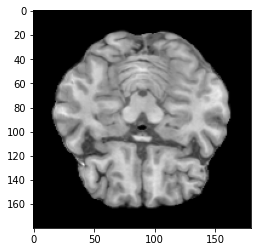

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

i = 15
print(slices[0,i,:,:,0].max())
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(slices[0,i,:,:,0], cmap="gray")
plt.show()

## 3D

In [245]:
import cv2

dimension = 120
x = 32
def get_slices_3d(path, category):
    img = sitk.ReadImage(path, sitk.sitkFloat64)
    arr = sitk.GetArrayFromImage(img)

    #normalize the matrix, numbers between 0.0 - 1.0
    #arr = arr / arr.max()
    
    slice = arr[68 - x :68,115:200,30:150]
    
    arr = np.zeros([x, dimension,dimension])
    
    for i in range(arr.shape[0]):
        arr[i, : , :] = cv2.resize(slice[i, : , :], (dimension, dimension), interpolation=cv2.INTER_CUBIC)
    
    slices = np.array([arr])
    slices = slices.reshape(1,arr.shape[0], arr.shape[1], arr.shape[2], 1)
    slices_cat = np.array([get_category(category)])
    
    return slices, slices_cat

In [246]:
def get_slices_per_group_3d(paths, categories):
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        if i == 0:
            group, group_cat = get_slices_3d(path, categories[i])
        else:
            new_group, new_group_cat = get_slices_3d(path, categories[i])
            group = np.concatenate((group, new_group))
            group_cat = np.concatenate((group_cat, new_group_cat))

        print("-> [%d/%d] Image processed." %(count,len(paths)))
        count+=1
    return group, group_cat

In [247]:
#test with one image
slices, slices_cat = get_slices_3d(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(1, 32, 120, 120, 1)
(1,)


In [248]:
slices, slices_cat = get_slices_per_group_3d(X_dataset[:3], y_dataset[:3])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Image processed.
-> [2/3] Image processed.
-> [3/3] Image processed.
(3, 32, 120, 120, 1)
(3,)


## AXIAL (3 channels)
arr[ xxx , : , : ] axial

In [249]:
import cv2

SLICE_NUMBER = 50
dim = 224
def get_slices_axial_3c(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)
  arr = arr[49:68,115:200,30:150]

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[arr.shape[0] - i -1, : , : ]
    slice = cv2.resize(slice, (dim, dim), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
        slice = cv2.merge((slice,slice,slice))
        if count == 0:
            slices = np.array([slice])
            slices_cat = np.array([get_category(category)])
        if count < SLICE_NUMBER:
            slices = np.concatenate((slices,[slice]))
            slices_cat = np.concatenate((slices_cat,[get_category(category)]))
        count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [21]:
def get_slices_per_group_axial_3c(paths, categories):
    
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        if i == 0:
            group, group_cat = get_slices_axial_3c(path, categories[i])
        else:
            try:
                new_group, new_group_cat = get_slices_axial_3c(path, categories[i])
                group = np.concatenate((group, new_group))
                group_cat = np.concatenate((group_cat, new_group_cat))
            except:
                print('error')

        print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
        count+=1
    return group, group_cat

In [22]:
#test with one image
i = 3
slices, slices_cat = get_slices_per_group_axial_3c(X_dataset[0:i], y_dataset[0:i])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Slices processed 20.
-> [2/3] Slices processed 40.
-> [3/3] Slices processed 60.
(60, 224, 224, 3)
(60,)


## AXIAL
arr[ xxx , : , : ] axial

In [26]:
import cv2

SLICE_NUMBER = 20
def get_slices_axial(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)
    
  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()
  arr = arr[49:68,115:200,30:150]
  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[arr.shape[0] - i -1, : , : ]
    slice = cv2.resize(slice, (120, 120), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      if count < SLICE_NUMBER:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [37]:
def get_slices_per_group_axial(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_axial(path, categories[i])
    else:
        try:
          new_group, new_group_cat = get_slices_axial(path, categories[i])
          group = np.concatenate((group, new_group))
          group_cat = np.concatenate((group_cat, new_group_cat))
        except:
            print("error")
    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [30]:
#test with one image
slices, slices_cat = get_slices_axial(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(20, 120, 120)
(20,)


## CORONAL
arr[ : , xxx , : ] coronal 

In [25]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_coronal(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, i , : ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [26]:
def get_slices_per_group_coronal(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_coronal(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_coronal(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [27]:
#test with one image
slices, slices_cat = get_slices_coronal(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(67, 224, 224)
(67,)


## SAGITAL
arr[ : , : , xxx ] sagital 

In [28]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_sagital(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, : , i ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [29]:
def get_slices_per_group_sagital(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_sagital(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_sagital(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [30]:
#test with one image
slices, slices_cat = get_slices_sagital(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(120, 224, 224)
(120,)


# MODEL (BINARY)

## Axial (Enssemble)

In [68]:
import os
import numpy as np
np.random.seed(777)
import math
import tensorflow as tf
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [45]:
X_axial3c_train, y_axial3c_train = get_slices_per_group_axial_3c(X_train[:100], y_train[:100])

-> [1/100] Slices processed 15.
-> [2/100] Slices processed 35.
-> [3/100] Slices processed 55.
-> [4/100] Slices processed 75.
-> [5/100] Slices processed 95.
-> [6/100] Slices processed 115.
-> [7/100] Slices processed 135.
-> [8/100] Slices processed 155.
-> [9/100] Slices processed 175.
-> [10/100] Slices processed 195.
-> [11/100] Slices processed 215.
-> [12/100] Slices processed 235.
-> [13/100] Slices processed 255.
-> [14/100] Slices processed 275.
-> [15/100] Slices processed 295.
-> [16/100] Slices processed 315.
-> [17/100] Slices processed 335.
-> [18/100] Slices processed 355.
-> [19/100] Slices processed 375.
-> [20/100] Slices processed 395.
-> [21/100] Slices processed 415.
-> [22/100] Slices processed 435.
-> [23/100] Slices processed 455.
-> [24/100] Slices processed 475.
-> [25/100] Slices processed 495.
-> [26/100] Slices processed 515.
-> [27/100] Slices processed 535.
-> [28/100] Slices processed 555.
-> [29/100] Slices processed 575.
-> [30/100] Slices processed

In [31]:
X_axial3c_test, y_axial3c_test = get_slices_per_group_axial_3c(X_test[1:], y_test[1:])

-> [1/60] Slices processed 20.
-> [2/60] Slices processed 40.
-> [3/60] Slices processed 60.
-> [4/60] Slices processed 80.
-> [5/60] Slices processed 100.
-> [6/60] Slices processed 120.
-> [7/60] Slices processed 140.
-> [8/60] Slices processed 160.
-> [9/60] Slices processed 180.
-> [10/60] Slices processed 200.
-> [11/60] Slices processed 220.
-> [12/60] Slices processed 240.
-> [13/60] Slices processed 260.
-> [14/60] Slices processed 280.
-> [15/60] Slices processed 300.
-> [16/60] Slices processed 320.
-> [17/60] Slices processed 340.
-> [18/60] Slices processed 360.
-> [19/60] Slices processed 380.
-> [20/60] Slices processed 400.
-> [21/60] Slices processed 420.
-> [22/60] Slices processed 440.
-> [23/60] Slices processed 460.
-> [24/60] Slices processed 480.
-> [25/60] Slices processed 500.
-> [26/60] Slices processed 520.
-> [27/60] Slices processed 540.
-> [28/60] Slices processed 560.
-> [29/60] Slices processed 580.
-> [30/60] Slices processed 600.
-> [31/60] Slices proce

In [ ]:
print(X_axial3c_train.shape, y_axial3c_train.shape)
#print(X_axial3c_test.shape, y_axial3c_test.shape)

In [36]:
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000
num_classes = 1

In [37]:
from tensorflow.keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model =VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor,outputs=predictions)

In [38]:
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications import VGG19

input_tensor = Input(shape = input_shape)  

base_model1=NASNetMobile(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model4=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

x4 = base_model4.output
x4 = GlobalAveragePooling2D()(x4)

merge = concatenate([x1, x2, x3 , x4])
predictions = Dense(1, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [39]:
bottleneck_final_model = Model(inputs=model.input, outputs=merge)

In [40]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [44]:
batch_size = 10
epochs = 1000
dropout_rate = 0.2

model = Sequential()
model.add(Flatten(input_shape=X_axial3c_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.sigmoid))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

checkpoint = ModelCheckpoint("vgg19_axial3c.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)
history = model.fit(X_axial3c_train, y_axial3c_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_reduce, es_callback],
                    validation_split=0.25,
                    verbose= 2)

Epoch 1/1000
75/75 - 17s - loss: 2092.1343 - accuracy: 0.6180 - val_loss: 608.7205 - val_accuracy: 0.5703
Epoch 2/1000
75/75 - 14s - loss: 234.2412 - accuracy: 0.6903 - val_loss: 94.7855 - val_accuracy: 0.5863
Epoch 3/1000
75/75 - 14s - loss: 10.9741 - accuracy: 0.6622 - val_loss: 0.5349 - val_accuracy: 0.6787
Epoch 4/1000


KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
preds = model.predict(X_axial3c_test)

predictions = [(0 if i <0.5 else 1) for i in preds]
cm = confusion_matrix(y_pred=predictions, y_true=y_axial3c_test)

print('Accuracy {}'.format(accuracy_score(y_true=y_axial3c_test, y_pred=predictions)))

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = ['parkinson', "parkinson + ICD"]

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_marix.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [ ]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
plt.savefig('model_acc.png', bbox_inches='tight', dpi = 100) 

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()
plt.savefig('model_pogress.png', bbox_inches='tight', dpi = 100) 

plt.figure()
N = len(history.history['accuracy'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('loss.png', bbox_inches='tight', dpi = 100) 

## 3D all brain

In [17]:
X_3d_all_train, y_3d_all_train = get_slices_per_group_3d_all(X_train[:50], y_train[:50])

-> [1/50] Image processed.
-> [2/50] Image processed.
-> [3/50] Image processed.
-> [4/50] Image processed.
-> [5/50] Image processed.
-> [6/50] Image processed.
-> [7/50] Image processed.
-> [8/50] Image processed.
-> [9/50] Image processed.
-> [10/50] Image processed.
-> [11/50] Image processed.
-> [12/50] Image processed.
-> [13/50] Image processed.
-> [14/50] Image processed.
-> [15/50] Image processed.
-> [16/50] Image processed.
-> [17/50] Image processed.
-> [18/50] Image processed.
-> [19/50] Image processed.
-> [20/50] Image processed.
-> [21/50] Image processed.
-> [22/50] Image processed.
-> [23/50] Image processed.
-> [24/50] Image processed.
-> [25/50] Image processed.
-> [26/50] Image processed.
-> [27/50] Image processed.
-> [28/50] Image processed.
-> [29/50] Image processed.
-> [30/50] Image processed.
-> [31/50] Image processed.
-> [32/50] Image processed.
-> [33/50] Image processed.
-> [34/50] Image processed.
-> [35/50] Image processed.
-> [36/50] Image processed.
-

In [271]:
X_3d_all_test, y_3d_all_test = get_slices_per_group_3d_all(X_test, y_test)

-> [1/48] Image processed.
-> [2/48] Image processed.
-> [3/48] Image processed.
-> [4/48] Image processed.
-> [5/48] Image processed.
-> [6/48] Image processed.
-> [7/48] Image processed.
-> [8/48] Image processed.
-> [9/48] Image processed.
-> [10/48] Image processed.
-> [11/48] Image processed.
-> [12/48] Image processed.
-> [13/48] Image processed.
-> [14/48] Image processed.
-> [15/48] Image processed.
-> [16/48] Image processed.
-> [17/48] Image processed.
-> [18/48] Image processed.
-> [19/48] Image processed.
-> [20/48] Image processed.
-> [21/48] Image processed.
-> [22/48] Image processed.
-> [23/48] Image processed.
-> [24/48] Image processed.
-> [25/48] Image processed.
-> [26/48] Image processed.
-> [27/48] Image processed.
-> [28/48] Image processed.
-> [29/48] Image processed.
-> [30/48] Image processed.
-> [31/48] Image processed.
-> [32/48] Image processed.
-> [33/48] Image processed.
-> [34/48] Image processed.
-> [35/48] Image processed.
-> [36/48] Image processed.
-

In [18]:
print("Train:",X_3d_all_train.shape, len(y_3d_all_train))
#print("Test:",X_3d_all_test.shape, len(y_3d_all_test))

Train: (50, 80, 180, 180, 1) 50


In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [20]:
model = Sequential()
model.add(Conv3D(input_shape=(80,180,180,1),filters=20,kernel_size=3,padding="same", activation="relu"))
model.add(Conv3D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 80, 180, 180, 20)  560       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 80, 180, 180, 64)  34624     
_________________________________________________________________
dropout (Dropout)            (None, 80, 180, 180, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 40, 90, 90, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 40, 90, 90, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 40, 90, 90, 128)   442496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 90, 90, 128)   0

In [21]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [22]:
checkpoint = ModelCheckpoint("vgg19_3d_all_5012022_1802.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
batch_size = 10
epochs = 1000
dropout_rate = 0.2

history = model.fit(X_3d_all_train, y_3d_all_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_reduce, es_callback],
                    validation_split=0.25,
                    verbose= 2)

Epoch 1/1000


## 3D

In [33]:
X_3d_train, y_3d_train = get_slices_per_group_3d(X_train, y_train)

-> [1/241] Image processed.
-> [2/241] Image processed.
-> [3/241] Image processed.
-> [4/241] Image processed.
-> [5/241] Image processed.
-> [6/241] Image processed.
-> [7/241] Image processed.
-> [8/241] Image processed.
-> [9/241] Image processed.
-> [10/241] Image processed.
-> [11/241] Image processed.
-> [12/241] Image processed.
-> [13/241] Image processed.
-> [14/241] Image processed.
-> [15/241] Image processed.
-> [16/241] Image processed.
-> [17/241] Image processed.
-> [18/241] Image processed.
-> [19/241] Image processed.
-> [20/241] Image processed.
-> [21/241] Image processed.
-> [22/241] Image processed.
-> [23/241] Image processed.
-> [24/241] Image processed.
-> [25/241] Image processed.
-> [26/241] Image processed.
-> [27/241] Image processed.
-> [28/241] Image processed.
-> [29/241] Image processed.
-> [30/241] Image processed.
-> [31/241] Image processed.
-> [32/241] Image processed.
-> [33/241] Image processed.
-> [34/241] Image processed.
-> [35/241] Image proce

In [34]:
X_3d_test, y_3d_test = get_slices_per_group_3d(X_test, y_test)

-> [1/61] Image processed.
-> [2/61] Image processed.
-> [3/61] Image processed.
-> [4/61] Image processed.
-> [5/61] Image processed.
-> [6/61] Image processed.
-> [7/61] Image processed.
-> [8/61] Image processed.
-> [9/61] Image processed.
-> [10/61] Image processed.
-> [11/61] Image processed.
-> [12/61] Image processed.
-> [13/61] Image processed.
-> [14/61] Image processed.
-> [15/61] Image processed.
-> [16/61] Image processed.
-> [17/61] Image processed.
-> [18/61] Image processed.
-> [19/61] Image processed.
-> [20/61] Image processed.
-> [21/61] Image processed.
-> [22/61] Image processed.
-> [23/61] Image processed.
-> [24/61] Image processed.
-> [25/61] Image processed.
-> [26/61] Image processed.
-> [27/61] Image processed.
-> [28/61] Image processed.
-> [29/61] Image processed.
-> [30/61] Image processed.
-> [31/61] Image processed.
-> [32/61] Image processed.
-> [33/61] Image processed.
-> [34/61] Image processed.
-> [35/61] Image processed.
-> [36/61] Image processed.
-

In [35]:
print("Train:",X_3d_train.shape, len(y_3d_train))
print("Test:",X_3d_test.shape, len(y_3d_test))

Train: (241, 32, 120, 120, 1) 241
Test: (61, 32, 120, 120, 1) 61


### VGG19 

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [37]:
model = Sequential()
model.add(Conv3D(input_shape=(32,120,120,1),filters=20,kernel_size=3,padding="same", activation="relu"))
model.add(Conv3D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 32, 120, 120, 20)  560       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 120, 120, 64)  34624     
_________________________________________________________________
dropout (Dropout)            (None, 32, 120, 120, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 60, 60, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 60, 60, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 60, 60, 128)   442496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 60, 60, 128)   0

In [41]:
checkpoint = ModelCheckpoint("vgg19_3d_3112-1856.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
hist = model.fit(X_3d_train, y_3d_train, batch_size=10,epochs=10,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/10
20/20 [==============================] - 3128s 156s/step - loss: 7.6737 - accuracy: 0.5833 - val_loss: 0.6914 - val_accuracy: 0.6735

Epoch 00001: val_accuracy improved from -inf to 0.67347, saving model to vgg19_3d_3112-1856.h5
Epoch 2/10
20/20 [==============================] - 3084s 154s/step - loss: 0.6954 - accuracy: 0.6562 - val_loss: 0.6852 - val_accuracy: 0.6735

Epoch 00002: val_accuracy did not improve from 0.67347
Epoch 3/10
20/20 [==============================] - 3148s 157s/step - loss: 0.6814 - accuracy: 0.6667 - val_loss: 0.6763 - val_accuracy: 0.6735

Epoch 00003: val_accuracy did not improve from 0.67347
Epoch 4/10
 4/20 [=====>........................] - ETA: 43:17 - loss: 0.6400 - accuracy: 0.8000

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.savefig('3d_graph_13122021.png')

In [ ]:
preds = model.predict(X_3d_test)

predictions = [(0 if i <0.5 else 1) for i in preds]
cm = confusion_matrix(y_pred=predictions, y_true=y_axial3c_test)

print('Accuracy {}'.format(accuracy_score(y_true=y_3d_test, y_pred=predictions)))

In [ ]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
plt.savefig('model_acc.png', bbox_inches='tight', dpi = 100) 

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()
plt.savefig('model_pogress.png', bbox_inches='tight', dpi = 100) 

plt.figure()
N = len(history.history['accuracy'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('loss.png', bbox_inches='tight', dpi = 100) 

## AXIAL

In [38]:
X_axial_train, y_axial_train = get_slices_per_group_axial(X_train, y_train)
X_axial_train = X_axial_train.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

X_axial_test, y_axial_test = get_slices_per_group_axial(X_test, y_test)
X_axial_test = X_axial_test.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

-> [1/214] Slices processed 20.
-> [2/214] Slices processed 40.
-> [3/214] Slices processed 60.
-> [4/214] Slices processed 75.
error
-> [5/214] Slices processed 75.
-> [6/214] Slices processed 88.
-> [7/214] Slices processed 108.
error
-> [8/214] Slices processed 108.
-> [9/214] Slices processed 128.
error
-> [10/214] Slices processed 128.
-> [11/214] Slices processed 146.
-> [12/214] Slices processed 166.
error
-> [13/214] Slices processed 166.
-> [14/214] Slices processed 186.
-> [15/214] Slices processed 206.
-> [16/214] Slices processed 226.
-> [17/214] Slices processed 246.
-> [18/214] Slices processed 266.
-> [19/214] Slices processed 286.
error
-> [20/214] Slices processed 286.
error
-> [21/214] Slices processed 286.
-> [22/214] Slices processed 306.
-> [23/214] Slices processed 326.
-> [24/214] Slices processed 346.
-> [25/214] Slices processed 361.
error
-> [26/214] Slices processed 361.
error
-> [27/214] Slices processed 361.
-> [28/214] Slices processed 364.
-> [29/214] Sli

AttributeError: 'NoneType' object has no attribute 'shape'

In [43]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_axial_train.shape[0],X_axial_train.shape[1],X_axial_train.shape[2],X_axial_train.shape[3], len(y_axial_train)))
#print("Test: X:(%d, %d, %d, %d), y: %d" %(X_axial_test.shape[0],X_axial_test.shape[1],X_axial_test.shape[2],X_axial_test.shape[3], len(y_axial_test)))

Train: X:(3251, 120, 120, 1), y: 3251


###VGG19

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [49]:
model = Sequential()
model.add(Conv2D(input_shape=(120,120,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 120, 120, 64)      640       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
dropout_10 (Dropout)         (None, 120, 120, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 60, 60, 128)       147584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 60, 128)      

In [50]:
checkpoint = ModelCheckpoint("vgg19_axial_20slices.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
hist = model.fit(X_axial_train, y_axial_train, batch_size=10,epochs=30,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/30
260/260 [==============================] - 799s 3s/step - loss: 0.7036 - accuracy: 0.5754 - val_loss: 0.6875 - val_accuracy: 0.5530

Epoch 00001: val_accuracy improved from -inf to 0.55300, saving model to vgg19_axial_20slices.h5
Epoch 2/30
260/260 [==============================] - 786s 3s/step - loss: 0.6823 - accuracy: 0.5769 - val_loss: 0.6876 - val_accuracy: 0.5530

Epoch 00002: val_accuracy did not improve from 0.55300
Epoch 3/30
260/260 [==============================] - 813s 3s/step - loss: 0.6823 - accuracy: 0.5769 - val_loss: 0.6889 - val_accuracy: 0.5530

Epoch 00003: val_accuracy did not improve from 0.55300
Epoch 4/30
260/260 [==============================] - 795s 3s/step - loss: 0.6822 - accuracy: 0.5769 - val_loss: 0.6877 - val_accuracy: 0.5530

Epoch 00004: val_accuracy did not improve from 0.55300
Epoch 5/30
260/260 [==============================] - 767s 3s/step - loss: 0.6817 - accuracy: 0.5769 - val_loss: 0.6894 - val_accuracy: 0.5530

Epoch 00005: val_a

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
test_results = model.evaluate(X_axial_test, y_axial_test)
test_results

# CORONAL

In [20]:
X_coronal_train, y_coronal_train = get_slices_per_group_coronal(X_train, y_train)
X_coronal_train = X_coronal_train.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/173] Slices processed 67.
-> [2/173] Slices processed 134.
-> [3/173] Slices processed 160.
-> [4/173] Slices processed 227.
-> [5/173] Slices processed 294.
-> [6/173] Slices processed 361.
-> [7/173] Slices processed 428.
-> [8/173] Slices processed 495.
-> [9/173] Slices processed 562.
-> [10/173] Slices processed 629.
-> [11/173] Slices processed 696.
-> [12/173] Slices processed 763.
-> [13/173] Slices processed 830.
-> [14/173] Slices processed 897.
-> [15/173] Slices processed 964.
-> [16/173] Slices processed 1031.


C:\Users\josie\AppData\Local\Temp/ipykernel_22212/1790016269.py:22: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [17/173] Slices processed 1212.
-> [18/173] Slices processed 1279.
-> [19/173] Slices processed 1346.
-> [20/173] Slices processed 1413.
-> [21/173] Slices processed 1480.
-> [22/173] Slices processed 1547.
-> [23/173] Slices processed 1570.
-> [24/173] Slices processed 1637.
-> [25/173] Slices processed 1704.
-> [26/173] Slices processed 1771.
-> [27/173] Slices processed 1838.
-> [28/173] Slices processed 1905.
-> [29/173] Slices processed 1972.
-> [30/173] Slices processed 2039.
-> [31/173] Slices processed 2106.
-> [32/173] Slices processed 2173.
-> [33/173] Slices processed 2240.
-> [34/173] Slices processed 2307.
-> [35/173] Slices processed 2374.
-> [36/173] Slices processed 2441.
-> [37/173] Slices processed 2508.
-> [38/173] Slices processed 2575.
-> [39/173] Slices processed 2642.
-> [40/173] Slices processed 2709.
-> [41/173] Slices processed 2776.
-> [42/173] Slices processed 2843.
-> [43/173] Slices processed 2910.
-> [44/173] Slices processed 2977.
-> [45/173] Slices p

In [21]:
X_coronal_test, y_coronal_test = get_slices_per_group_coronal(X_test, y_test)
X_coronal_test = X_coronal_test.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/44] Slices processed 67.
-> [2/44] Slices processed 134.
-> [3/44] Slices processed 198.
-> [4/44] Slices processed 265.
-> [5/44] Slices processed 332.
-> [6/44] Slices processed 399.
-> [7/44] Slices processed 466.
-> [8/44] Slices processed 533.
-> [9/44] Slices processed 600.
-> [10/44] Slices processed 667.
-> [11/44] Slices processed 734.
-> [12/44] Slices processed 801.
-> [13/44] Slices processed 868.
-> [14/44] Slices processed 935.
-> [15/44] Slices processed 1002.
-> [16/44] Slices processed 1069.
-> [17/44] Slices processed 1136.
-> [18/44] Slices processed 1203.
-> [19/44] Slices processed 1270.
-> [20/44] Slices processed 1337.
-> [21/44] Slices processed 1404.
-> [22/44] Slices processed 1471.
-> [23/44] Slices processed 1538.
-> [24/44] Slices processed 1605.
-> [25/44] Slices processed 1672.
-> [26/44] Slices processed 1739.
-> [27/44] Slices processed 1806.
-> [28/44] Slices processed 1873.
-> [29/44] Slices processed 1940.
-> [30/44] Slices processed 2007.
-> [

In [22]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_coronal_train.shape[0],X_coronal_train.shape[1],X_coronal_train.shape[2],X_coronal_train.shape[3], len(y_coronal_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_coronal_test.shape[0],X_coronal_test.shape[1],X_coronal_test.shape[2],X_coronal_test.shape[3], len(y_coronal_test)))

Train: X:(11556, 224, 224, 1), y: 11556
Test: X:(2945, 224, 224, 1), y: 2945


# VGG19

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imageio
import tensorflow as tf

In [23]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 128)    

In [22]:
checkpoint = ModelCheckpoint("vgg19_coronal.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
hist = model.fit(X_coronal_train, y_coronal_train, batch_size=10,epochs=50,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/50
928/928 [==============================] - 8392s 9s/step - loss: nan - accuracy: 0.5174 - val_loss: nan - val_accuracy: 0.6246

Epoch 00001: val_accuracy improved from -inf to 0.62457, saving model to vgg19_coronal.h5
Epoch 2/50
928/928 [==============================] - 8386s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00002: val_accuracy did not improve from 0.62457
Epoch 3/50
928/928 [==============================] - 8388s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00003: val_accuracy did not improve from 0.62457
Epoch 4/50
928/928 [==============================] - 8408s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00004: val_accuracy did not improve from 0.62457
Epoch 5/50
928/928 [==============================] - 8387s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00005: val_accuracy did not improve from 0.6

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [24]:
model.load_weights("./vgg19_coronal.h5")
test_results = model.evaluate(X_coronal_test, y_coronal_test)
test_results

93/93 [==============================] - 561s 6s/step - loss: 0.6890 - accuracy: 0.4540


[0.6889810562133789, 0.45398980379104614]

# Sagital

In [34]:
X_sagital_train, y_sagital_train = get_slices_per_group_sagital(X_train, y_train)
X_sagital_train = X_sagital_train.reshape(-1, X_sagital_train.shape[1], X_sagital_train.shape[2], 1)

-> [1/214] Slices processed 153.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 0 dimension(s)

In [ ]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_sagital_train.shape[0],X_sagital_train.shape[1],X_sagital_train.shape[2],X_sagital_train.shape[3], len(y_sagital_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_sagital_test.shape[0],X_sagital_test.shape[1],X_sagital_test.shape[2],X_sagital_test.shape[3], len(y_sagital_test)))

#EXTRA

In [92]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import cv2
img = sitk.ReadImage(PD_file_paths[10], sitk.sitkFloat64)
arr = sitk.GetArrayFromImage(img)

slice = arr[50:68,115:200,30:150]

print(slice.shape, slice.min())



(18, 85, 120) 0.0


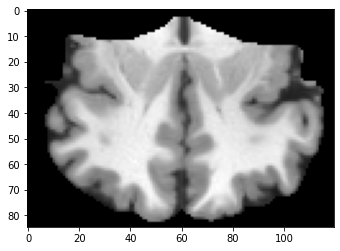

In [93]:
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(slice[-1,:,:], cmap="gray")
plt.show()

In [ ]:
arr_reshaped = cv2.resize(arr[:, : , 100], (224, 224), interpolation=cv2.INTER_CUBIC)
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

In [33]:
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

NameError: name 'arr_reshaped' is not defined

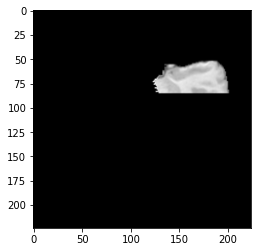

In [15]:
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(arr_reshaped, cmap="gray") 

plt.show()

In [5]:
BUY_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/BUY/*/ex_*.nii.gz"))  #68 files
EAT_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/EAT/*/ex_*.nii.gz")) #81files
GAMBLE_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/GAMBLE/*/ex_*.nii.gz"))  #7 files
SEX_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/SEX/*/ex_*.nii.gz"))  #42 files

PD_file_paths =  sorted(glob("E:/ESPOL/integradora/images_preprocessed/PD/*/ex_*.nii.gz"))  #100 files

NameError: name 'glob' is not defined

In [6]:
print(len(BUY_file_paths), BUY_file_paths[:3])
print(len(EAT_file_paths), EAT_file_paths[:3])
print(len(GAMBLE_file_paths), GAMBLE_file_paths[:3])
print(len(SEX_file_paths), SEX_file_paths[:3])

print(len(PD_file_paths), PD_file_paths[:3])

NameError: name 'BUY_file_paths' is not defined

In [3]:
import os
import shutil
import subprocess

In [4]:
destiny = "E:/ESPOL/integradora/desorders/PREPROCESSED/" + "BUY/"

for file in BUY_file_paths:
    id = file.split("\\")[1]
    shutil.copyfile(file, destiny + id + ".nii.gz")

NameError: name 'BUY_file_paths' is not defined